#### Analyzing the Air Pollution Decrease Caused by the Global COVID-19 Pandemic 

Last December 2019, we heard about the first __[COVID-19](https://www.who.int/emergencies/diseases/novel-coronavirus-2019/events-as-they-happen)__ cases in China.

Now, three months later, the WHO has officially declared Coronavirus outbreak as a pandemic and also an __[emergency of international concern](http://www.euro.who.int/en/health-topics/health-emergencies/international-health-regulations/news/news/2020/2/2019-ncov-outbreak-is-an-emergency-of-international-concern)__. 

The ongoing outbreak doesn't giving signs of getting better in any way, however, there is alway something good in bad. The air pollution has decreased dramatically over past month and they are saying that it could same even more lives than COVID-19 takes. In light of that, we would like to introduce a __[high-quality global air pollution reanalysis](http://data.planetos.com/datasets/ecmwf_cams_reanalysis_global)__ and __[high-quality global air pollution near-realtime forecast dataset](https://data.planetos.com/datasets/cams_nrt_forecasts_global)__ we have in the Planet OS Datahub where the first one provides air quality data from 2008-2018 and second a 5-day air quality forecast.

The Copernicus Atmosphere Monitoring Service uses a comprehensive global monitoring and forecasting system that estimates the state of the atmosphere on a daily basis, combining information from models and observations, to provide a daily 5-day global surface forecast. 
The CAMS reanalysis dataset covers the period January 2003 to 2018. The CAMS reanalysis is the latest global reanalysis data set of atmospheric composition (AC) produced by the Copernicus Atmosphere Monitoring Service (CAMS), consisting of 3-dimensional time-consistent AC fields, including aerosols, chemical species and greenhouse gases (GHGs). The data set builds on the experience gained during the production of the earlier MACC reanalysis and CAMS interim reanalysis.

In this analysis we’ve used PM2.5 in the analysis as these particles, often described as the fine particles, are up to 30 times smaller than the width of a human hair. These tiny particles are small enough to be breathed deep into the lungs, making them very dangerous to people’s health.

As we would like to have data about large areas we will download data by using Package API.

In [89]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
import ipywidgets as widgets
from mpl_toolkits.basemap import Basemap,shiftgrid
import dh_py_access.package_api as package_api
import matplotlib.colors as colors
import pandas as pd
import warnings
import shutil
import imageio
import datetime
import os
warnings.filterwarnings("ignore")

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [4]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

At first, we need to define the dataset name and a variable we want to use.

In [14]:
dh = datahub.datahub(server,version,API_key)
dataset_nrt = 'cams_nrt_forecasts_global'
dataset_rean = 'ecmwf_cams_reanalysis_global_v1'
variable_name1 = 'pm2p5'

Then we define spatial range. We decided to analyze US, where unfortunately catastrofic wildfires are taking place at the moment and influeces air quality. 

In [15]:
area_name = 'Europe'

latitude_north = 63; longitude_west = -18
latitude_south = 35; longitude_east = 30

time_start = '2008-01-01T00:00:00'
time_end = '2019-01-01T00:00:00'

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

In [16]:
package_cams = package_api.package_api(dh,dataset_rean,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,time_start=time_start,time_end=time_end,area_name=area_name)

In [17]:
package_cams.make_package()

http://api.planetos.com/v1/packages?apikey=03d010c205c84acd98ac21e3f1827662&dataset=ecmwf_cams_reanalysis_global_v1&package=ecmwf_cams_reanalysis_global_v1_20080101T000000to20190101T000000_Europe&z=all&polygon=%5B%5B-18%2C+35%5D%2C+%5B30%2C+35%5D%2C+%5B30%2C+63%5D%2C+%5B-18%2C+63%5D%2C+%5B-18%2C+35%5D%5D&time_start=2008-01-01T00%3A00%3A00&time_end=2019-01-01T00%3A00%3A00&var=pm2p5


In [18]:
package_cams.download_package()

In [28]:
package_cams_nrt = package_api.package_api(dh,dataset_nrt,variable_name1,longitude_west,longitude_east,latitude_south,latitude_north,area_name=area_name)
package_cams_nrt.make_package()
package_cams_nrt.download_package()

http://api.planetos.com/v1/packages?apikey=03d010c205c84acd98ac21e3f1827662&dataset=cams_nrt_forecasts_global&package=cams_nrt_forecasts_global_recent_reftime_20200320_Europe&z=all&polygon=%5B%5B-18%2C+35%5D%2C+%5B30%2C+35%5D%2C+%5B30%2C+63%5D%2C+%5B-18%2C+63%5D%2C+%5B-18%2C+35%5D%5D&reftime_recent=true&var=pm2p5


### Work with the downloaded files

We start with opening the files with xarray and adding PM2.5 as micrograms per cubic meter as well to make the values easier to understand and compare. After that, we will create a map plot with a time slider, then make a GIF using the images, and finally, we will look into a specific location.

In [91]:
dd1 = xr.open_dataset(package_cams.local_file_name)
dd1['lon'] = dd1['lon']
dd1['pm2p5_micro'] = dd1.pm2p5 * 1000000000.
dd1.pm2p5_micro.data[dd1.pm2p5_micro.data < 0] = np.nan

In [98]:
dd2 = xr.open_dataset(package_cams_nrt.local_file_name)
dd2['pm2p5_micro'] = dd2.pm2p5 * 1000000000.
dd2.pm2p5_micro.data[dd2.pm2p5_micro.data < 0] = np.nan

In [100]:
year_ago = (pd.to_datetime(dd2.time[0].data) - datetime.timedelta(days=365+366)).strftime('%Y-%m-%dT%H:%M:%S')
data_rean = dd1.pm2p5_micro.sel(time=str(year_ago))
data_nrt= dd2.pm2p5_micro[0]

data_rean_shifted, lon1 = shiftgrid(180,data_rean,dd1.lon.values,start=False)
data_nrt_shifted, lon2 = shiftgrid(180,data_nrt,dd2.longitude.values,start=False)

Here we are making a Basemap of the US that we will use for showing the data.

In [34]:
dd2

<xarray.Dataset>
Dimensions:      (latitude: 70, longitude: 120, time: 121)
Coordinates:
  * time         (time) datetime64[ns] 2020-03-19T12:00:00 ... 2020-03-24T12:00:00
  * latitude     (latitude) float32 62.8 62.4 62.0 61.6 ... 36.4 36.0 35.6 35.2
  * longitude    (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
Data variables:
    pm2p5        (time, latitude, longitude) float32 1.9426807e-09 ... 4.0628944e-08
    ref_time     datetime64[ns] ...
    lon          (longitude) float32 0.0 0.3999939 ... -0.7999878 -0.4000244
    lat          (latitude) float32 62.8 62.4 62.0 61.6 ... 36.4 36.0 35.6 35.2
    pm2p5_micro  (time, latitude, longitude) float32 1.9426807 ... 40.628944

In [94]:
m = Basemap(projection='merc', lat_0 = 55, lon_0 = -4,
         resolution = 'i', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)
lons,lats = np.meshgrid(lon1,dd1.lat.data)
lonmap,latmap = m(lons,lats)
lons_n,lats_n = np.meshgrid(lon2,dd2.latitude.data)
lonmap_nrt,latmap_nrt = m(lons_n,lats_n)

Now it is time to plot all the data. A great way to do it is to make an interactive widget, where you can choose time stamp by using a slider. 

As the minimum and maximum values are very different, we are using logarithmic colorbar to visualize it better.

On the map we can see that the very high PM2.5 values are in different states. Maximums are most of the time near 1000 µg/m3, which is way larger than the norm (25 µg/m3). By using the slider we can see the air quality forecast, which shows how the pollution is expected to expand. 

We are also adding a red dot to the map to mark the area, where the PM2.5 is the highest. Seems like it is moving a lot and many wild fires are influencing it. We can also see that most of the Continental US is having PM2.5 values below the standard, which is 25 µg/m3, but in the places where wild fires taking place, values tend to be at least over 100 µg/m3.

In [85]:
vmax = 100
vmin = 1

In [104]:
dd1

<xarray.Dataset>
Dimensions:      (lat: 40, lon: 68, time: 32144)
Coordinates:
  * time         (time) datetime64[ns] 2008-01-01 ... 2018-12-31T21:00:00
  * lat          (lat) float32 62.806805 62.105057 ... 36.14027 35.43852
  * lon          (lon) float32 0.0 0.70312333 1.4062467 ... 358.5929 359.29602
Data variables:
    pm2p5        (time, lat, lon) float32 1.553417e-09 ... 3.955349e-08
    pm2p5_micro  (time, lat, lon) float32 1.553417 6.292515 ... 39.55349

In [105]:
dd2

<xarray.Dataset>
Dimensions:      (latitude: 70, longitude: 120, time: 121)
Coordinates:
  * time         (time) datetime64[ns] 2020-03-19T12:00:00 ... 2020-03-24T12:00:00
  * latitude     (latitude) float32 62.8 62.4 62.0 61.6 ... 36.4 36.0 35.6 35.2
  * longitude    (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
Data variables:
    pm2p5        (time, latitude, longitude) float32 1.9426807e-09 ... 4.0628944e-08
    ref_time     datetime64[ns] ...
    pm2p5_micro  (time, latitude, longitude) float32 1.9426807 ... 40.628944

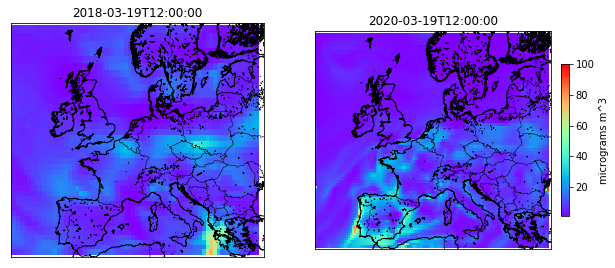

In [103]:

fig=plt.figure(figsize=(10,7))
ax = fig.add_subplot(121)
pcm = m.pcolormesh(lonmap,latmap,data_rean_shifted,
            vmin = vmin,vmax=vmax,cmap = 'rainbow')
plt.title(str(data_rean.time.data)[:-10])

m.drawcoastlines()
m.drawcountries()
m.drawstates()

ax2 = fig.add_subplot(122)
pcm2 =  m.pcolormesh(lonmap_nrt,latmap_nrt,data_nrt_shifted,
            vmin = vmin,vmax=vmax,cmap = 'rainbow')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

cbar = plt.colorbar(pcm,fraction=0.03, pad=0.040)
plt.title(str(data_nrt.time.data)[:-10])
cbar.set_label('micrograms m^3')

plt.savefig('201819marchvs2020.png',dpi=300)

Let's include an image from the last time-step as well, because GitHub Preview doesn't show the time slider images. 

With the function below we will save images you saw above to the local filesystem as a GIF, so it is easily shareable with others. 

In [13]:
def make_ani():
    folder = './anim/'
    for k in range(len(dd1.pm2p5_micro)):
        filename = folder + 'ani_' + str(k).rjust(3,'0') + '.png'
        if not os.path.exists(filename):
            fig=plt.figure(figsize=(10,7))
            ax = fig.add_subplot(111)
            pcm = m.pcolormesh(lonmap,latmap,dd1.pm2p5_micro.data[k],
                        norm = colors.LogNorm(vmin=vmin, vmax=vmax),cmap = 'rainbow')
            m.drawcoastlines()
            m.drawcountries()
            m.drawstates()
            cbar = plt.colorbar(pcm,fraction=0.02, pad=0.040,ticks=[10**0, 10**1, 10**2,10**3])
            cbar.ax.set_yticklabels([0,10,100,1000]) 
            plt.title(str(dd1.pm2p5_micro.time[k].data)[:-10])
            ax.set_xlim()
            cbar.set_label('micrograms m^3')
            if not os.path.exists(folder):
                os.mkdir(folder)
            plt.savefig(filename,bbox_inches = 'tight')
            plt.close()

    files = sorted(os.listdir(folder))
    images = []
    for file in files:
        if not file.startswith('.'):
            filename = folder + file
            images.append(imageio.imread(filename))
    kargs = { 'duration': 0.1,'quantizer':2,'fps':5.0}
    imageio.mimsave('cams_pm2p5.gif', images, **kargs)
    print ('GIF is saved as cams_pm2p5.gif under current working directory')
    shutil.rmtree(folder)
make_ani()

GIF is saved as cams_pm2p5.gif under current working directory


To see data more specifically we need to choose the location. This time we decided to look into Los Angeles and San Fransisco, as the most populated cities in California.

In [14]:
lon = -118; lat = 34
data_in_spec_loc = dd1.sel(longitude = lon,latitude=lat,method='nearest')
print ('Latitude ' + str(lat) + ' ; Longitude ' + str(lon))

Latitude 34 ; Longitude -118


In the plot below we can see the PM2.5 forecast on the surface layer. Note that the time zone on the graph is UTC while the time zone in San Fransisco and Los Angeles is UTC-08:00. The air pollution from the wildfire has exceeded a record  100 µg/m3, while the hourly norm is 25 µg/m3. We can also see some peaks every day around 12 pm UTC (4 am PST) and the lowest values are around 12 am UTC (4 pm PST). 

Daily pm 2.5 values are mostly in the norm, while the values will continue to be high during the night. This daily pattern where the air quality is the worst at night is caused by the __[*temperature inversion*](http://en.ilmatieteenlaitos.fi/temperature-inversions)__. As the land is not heated by the sun during the night, and the winds tend to be weaker as well, the pollution gets trapped near the ground. Pollution also tends to be higher in the winter time when the days are shorter. Thankfully day time values are much smaller.

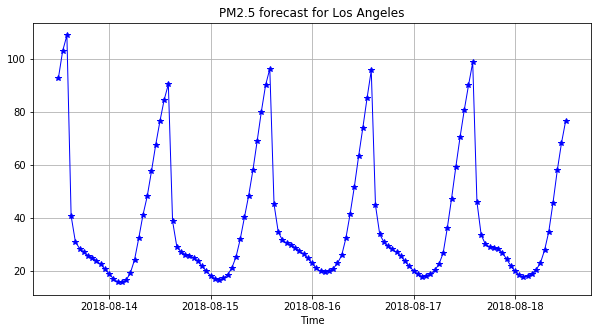

In [15]:
fig = plt.figure(figsize=(10,5))
plt.plot(data_in_spec_loc.time,data_in_spec_loc.pm2p5_micro, '*-',linewidth = 1,c='blue',label = dataset) 
plt.xlabel('Time')
plt.title('PM2.5 forecast for Los Angeles')
plt.grid()

In [16]:
lon = -122.4; lat = 37.7
data_in_spec_loc = dd1.sel(longitude = lon,latitude=lat,method='nearest')
print ('Latitude ' + str(lat) + ' ; Longitude ' + str(lon))

Latitude 37.7 ; Longitude -122.4


Thankfully, San Fransisco air quality is in the norm even in the night time. However, we have to be careful as it could easily change with the wind direction as the fires are pretty close to the city. We can also see that in the end of the forecast values are rising quite rapidly. 

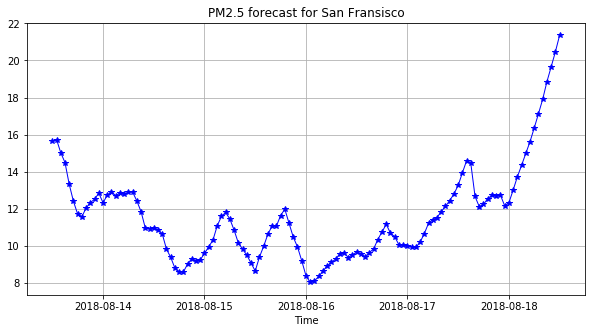

In [17]:
fig = plt.figure(figsize=(10,5))
plt.plot(data_in_spec_loc.time,data_in_spec_loc.pm2p5_micro, '*-',linewidth = 1,c='blue',label = dataset) 
plt.xlabel('Time')
plt.title('PM2.5 forecast for San Fransisco')
plt.grid()

Finally, we will remove the package we downloaded. 

In [18]:
os.remove(package_cams.local_file_name)

This analysis is made on August 14, 2018. 